# Importing all the required modules

In [1]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [2]:
%%time

!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip uninstall -q tqdm -y > /dev/null
!pip install -q tqdm==4.48.1 > /dev/null
!pip uninstall -q torch -y > /dev/null
!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install -q -U tokenizers==0.7.0 > /dev/null
!pip install -q -U transformers==3.0.2 > /dev/null
!pip install -q -U simpletransformers==0.46.0 > /dev/null

     |████████████████████████████████| 2.1 MB 11.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you have torch 1.6.0+cu101 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you have torch 1.6.0+cu101 which is incompatible.
allennlp 1.0.0 requires transformers<2.12,>=2.9, but you have transformers 3.0.2 which is incompatible.
CPU times: user 1.68 s, sys: 470 ms, total: 2.15 s
Wall time: 1min 48s


In [3]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


('1.6.0+cu101', '3.0.2', '0.8.1.rc1')

# Lazy Loading JSON Data Using yield

This sample of code shows how to open a large JSON file via Python's yield keyword in a memory-efficient manner. The <b>get_metadata()</b> function loads every line of the JSON file one that a time rather than loading the entire file into memory at once, that could cause memory problems for large files.

In [4]:
get_the_file = '../input/arxiv/arxiv-metadata-oai-snapshot.json'

""" Using `yield` to load the JSON file in a loop to prevent Python memory issues if JSON is loaded directly"""

def get_data():
    with open(get_the_file, 'r') as f:
        for thing in f:
            yield thing

# Extracting Metadata from JSON File

This code uses the <b>get_metadata()</b> generator function to iterate in the metadata of papers stored in a JSON file. To avoid memory problems, the JSON data is loaded slowly, line by line. After parsing every JSON object, the first paper's key-value pairs are printed.

In [5]:
paper_metadata = get_data()
for paper in paper_metadata:
    for k, v in json.loads(paper).items():
        print(f'{k}: {v} \n')
    break

id: 0704.0001 

submitter: Pavel Nadolsky 

authors: C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan 

title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies 

comments: 37 pages, 15 figures; published version 

journal-ref: Phys.Rev.D76:013009,2007 

doi: 10.1103/PhysRevD.76.013009 

report-no: ANL-HEP-PR-07-12 

categories: hep-ph 

license: None 

abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
m

# Mapping Scientific Fields in ArXiv Metadata

The full names of the scientific fields that are mapped to their abbreviations in the ArXiv metadata are provided by this dictionary. Knowing the field of research items and classifying them appropriately can be aided by this mapping.

In [6]:
sci_field_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}


# Text classification using **RoBERTa**

In [7]:
%%time

paper_titles = []
paper_intro = []
paper_type = []

paper_categories = np.array(list(sci_field_map.keys())).flatten()

metadata_of_paper = get_data()
for paper in tqdm(metadata_of_paper):
    papers_dict = json.loads(paper)
    category = papers_dict.get('categories')
    try:
        try:
            year = int(papers_dict.get('journal-ref')[-4:])
        except:
            year = int(papers_dict.get('journal-ref')[-5:-1])

        if category in paper_categories and 2010<year<2021:
            paper_titles.append(papers_dict.get('title'))
            paper_intro.append(papers_dict.get('abstract'))
            paper_type.append(papers_dict.get('categories'))
    except:
        pass 

len(paper_titles), len(paper_intro), len(paper_type)


CPU times: user 1min 11s, sys: 3.31 s, total: 1min 14s
Wall time: 1min 21s


(117815, 117815, 117815)

# Preprocessing ArXiv Metadata for Multi-label Classification

This code cell prepares it for multi-label classification tasks by processing metadata from ArXiv papers. It creates a DataFrame with the titles, abstracts, and related categories of the papers. Cleaning abstracts, integrating them with titles, balancing categories to lessen class imbalance, shortlisting groups based on frequency, and storing categories into a form that can be used for modeling are all steps in the process. After creating a DataFrame, the code removes temporary variables to guarantee memory efficiency.


In [8]:
%%time

papers_dataframe = pd.DataFrame({
    'title': paper_titles,
    'abstract': paper_intro,
    'categories': paper_type
})

papers_dataframe['abstract'] = papers_dataframe['abstract'].apply(lambda x: x.replace("\n",""))
papers_dataframe['abstract'] = papers_dataframe['abstract'].apply(lambda x: x.strip())
papers_dataframe['text'] = papers_dataframe['title'] + '. ' + papers_dataframe['abstract']

papers_dataframe['categories'] = papers_dataframe['categories'].apply(lambda x: tuple(x.split()))

# Choosing paper categories based on their frequency & eliminating categories with very few papers
shortlisted_categories = papers_dataframe['categories'].value_counts().reset_index(name="count").query("count > 250")["index"].tolist()
papers_dataframe = papers_dataframe[papers_dataframe["categories"].isin(shortlisted_categories)].reset_index(drop=True)

# Shuffle DataFrame
papers_dataframe = papers_dataframe.sample(frac=1).reset_index(drop=True)

# Sample roughtly equal number of texts from different paper categories (to reduce class imbalance issues)
papers_dataframe = papers_dataframe.groupby('categories').head(250).reset_index(drop=True)

multi_label_encoder = MultiLabelBinarizer()
multi_label_encoder.fit(papers_dataframe['categories'])
papers_dataframe['categories_encoded'] = papers_dataframe['categories'].apply(lambda x: multi_label_encoder.transform([x])[0])

papers_dataframe = papers_dataframe[["text", "categories", "categories_encoded"]]
del paper_titles, paper_intro, paper_type
papers_dataframe

CPU times: user 2.1 s, sys: 143 ms, total: 2.24 s
Wall time: 2.25 s


,text,categories,categories_encoded
0,Phase diagrams of Majorana-Hubbard ladders. Mo...,"(cond-mat.str-el,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,Imaginary-time matrix product state impurity s...,"(cond-mat.str-el,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Determining the vortex tilt relative to a supe...,"(cond-mat.supr-con,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,Description and Technical specification of Cyb...,"(cs.RO,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Three Point Tree Level Amplitude in Superstrin...,"(hep-th,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
14495,Fixation in large populations: a continuous vi...,"(q-bio.PE,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14496,Statistical physics methods provide the exact ...,"(q-bio.PE,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14497,Invasion rate versus diversity in population d...,"(q-bio.PE,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14498,"Humans: the hyper-dense species. Humans, like ...","(q-bio.PE,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Training a Multi-Label Classification Model with RoBERTa

This code is meant to train a model using machine learning that can concurrently classify ArXiv papers into several scientific categories. Through utilizing RoBERTa's pre-trained depictions and refining them for the particular task, the model gains the ability to comprehend the context of abstracts and paper titles and forecast pertinent scientific fields.

In [9]:
%%time

from simpletransformers.classification import MultiLabelClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False, # Model occupies 1.4GB size per epoch (Total Disk Space Available: 4.9GB)
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('roberta', 
                                      'roberta-base', 
                                      num_labels=len(shortlisted_categories), 
                                      args=model_args)


CPU times: user 17 s, sys: 1.9 s, total: 18.8 s
Wall time: 22 s


# Training and Evaluating a Multi-Label Classification Model

This code uses the prepared ArXiv paper dataset to train and assess a multi-label classification model. The model's performance can be evaluated on unobserved data by dividing the dataset into training and evaluation subsets. This allows for an assessment of the model's efficacy in predicting the pertinent scientific categories for papers.

In [10]:
%%time

trained_dataframe, evaluated_dataframe = train_test_split(papers_dataframe, test_size=0.1, stratify=papers_dataframe["categories"], random_state=42)

# Train the model
model.train_model(trained_dataframe[["text", "categories_encoded"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(evaluated_dataframe[["text", "categories_encoded"]])
print(result)



{'LRAP': 0.7693910855658913, 'eval_loss': 0.037078711992272965}
CPU times: user 51min 43s, sys: 10.3 s, total: 51min 53s
Wall time: 52min 24s


In [ ]:
# Save the trained model configuration
model.config.save_pretrained("model_roberta")

# Save the trained model weights
model.model.save_pretrained("model_roberta")

# Convert the saved model to .h5 format
from transformers import RobertaForSequenceClassification, RobertaConfig

# Load the saved model configuration
config = RobertaConfig.from_pretrained("model_roberta")

# Load the saved model weights
model_roberta = RobertaForSequenceClassification.from_pretrained("model_roberta", config=config)

# Save the model in .h5 format
model_roberta.save_pretrained("model_roberta.h5")





### #1.4 Plot Heatmap 📉

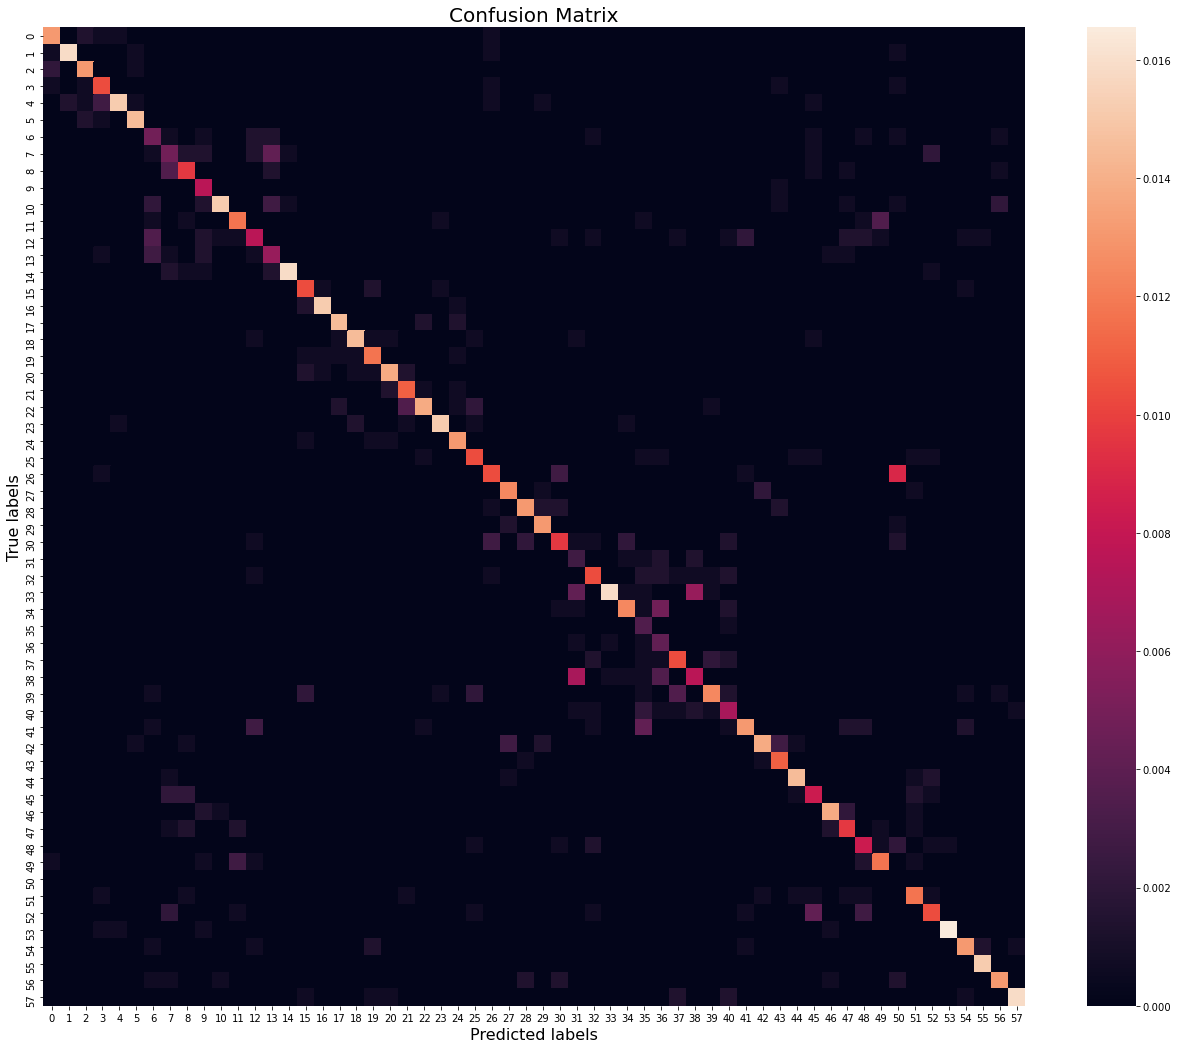

In [11]:
pred_categories = list(map(lambda x: np.argmax(x), model_outputs))
evaluated_labels = evaluated_dataframe["categories_encoded"].apply(lambda x: np.argmax(x)).tolist()

plt.figure(figsize=(22,18))
papers_confusion_matrix = confusion_matrix(pred_categories, evaluated_labels)
ax = sns.heatmap(papers_confusion_matrix/np.sum(papers_confusion_matrix))
ax.set_xlabel('Predicted labels', fontsize=16)
ax.set_ylabel('True labels', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=20)

plt.show()

### (Experimental: Heatmap with labels)

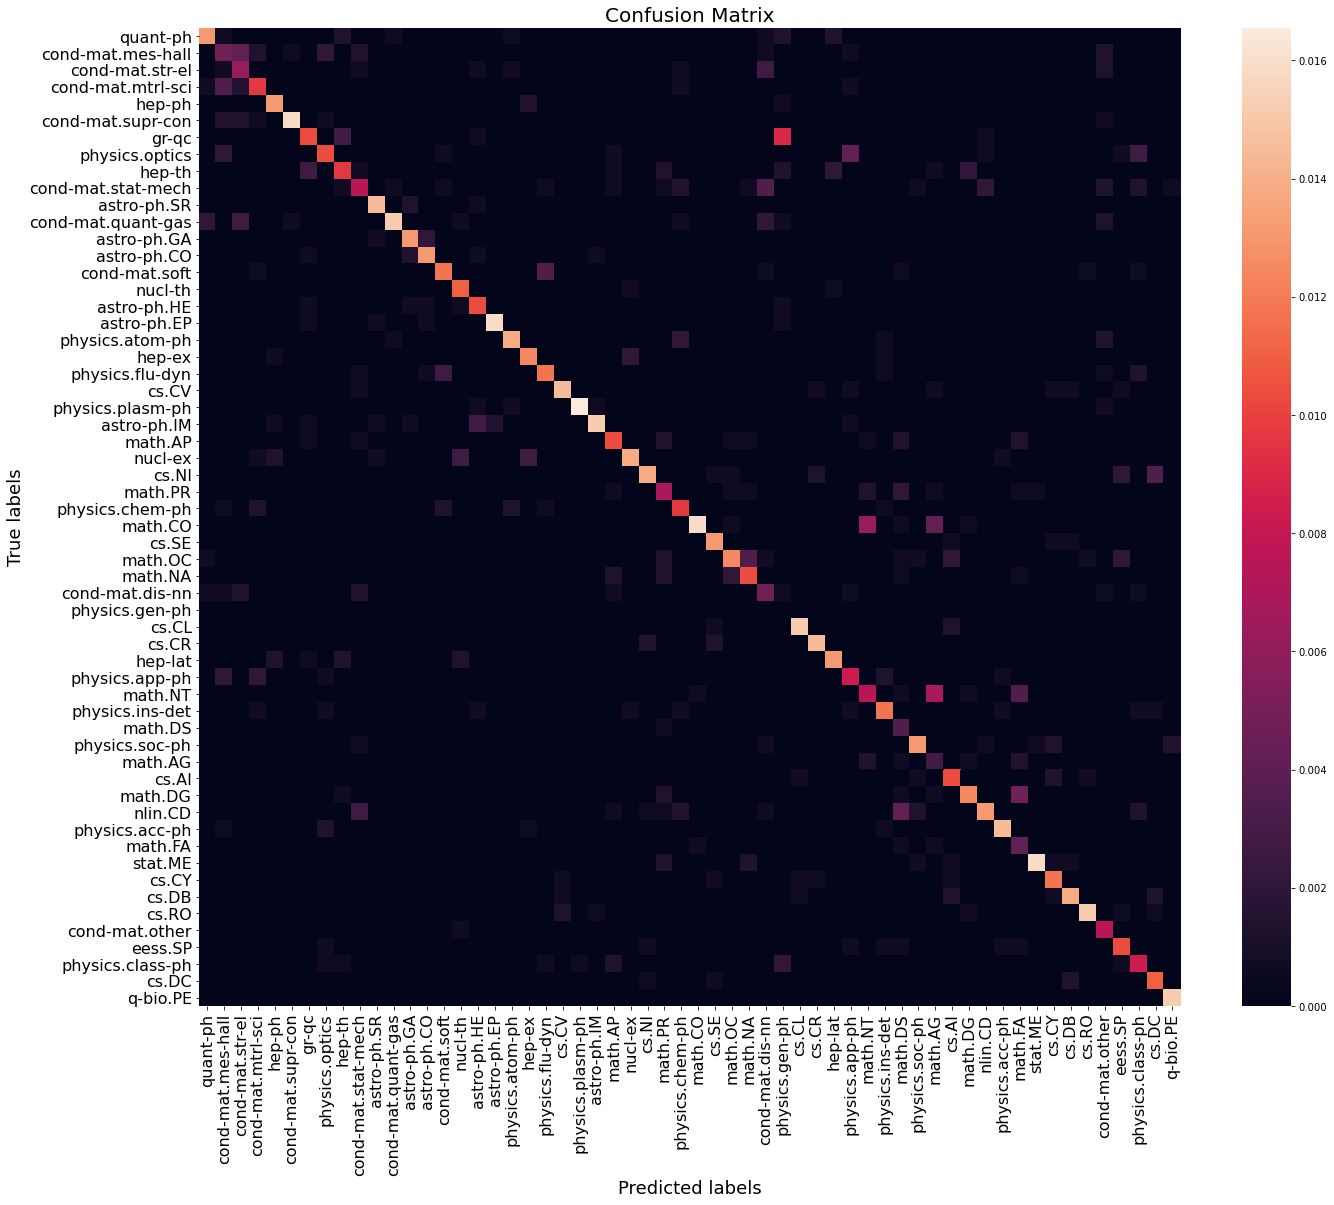

In [12]:
predicted_categories_argmax = list(map(lambda x: np.argmax(x), model_outputs))

predicted_categories = np.eye(len(shortlisted_categories))[predicted_categories_argmax]
pred_categories = multi_label_encoder.inverse_transform(predicted_categories)

evaluated_labels = evaluated_dataframe["categories"].tolist()

shortlisted_categories_formatted = list(map(lambda x: list(x)[0], shortlisted_categories))

plt.figure(figsize=(22,18))
papers_confusion_matrix = confusion_matrix(pred_categories, evaluated_labels, shortlisted_categories_formatted)
ax = sns.heatmap(papers_confusion_matrix/np.sum(papers_confusion_matrix))
ax.set_xlabel('Predicted labels', fontsize=18)
ax.set_ylabel('True labels', fontsize=18)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(shortlisted_categories_formatted, rotation=90, fontsize=16)
ax.set_yticklabels(shortlisted_categories_formatted, rotation=0, fontsize=16)

plt.show()

### #1.5 Prediction 🔮

In [13]:
import random

for _ in range(50):
    random_idx = random.randint(0, len(evaluated_dataframe)-1)
    text = evaluated_dataframe.iloc[random_idx]['text']
    true_categories = evaluated_dataframe.iloc[random_idx]['categories']

    # Predict with trained multilabel classification model
    predicted_categories_encoded, raw_outputs = model.predict([text])
    predicted_categories_encoded = np.array(predicted_categories_encoded)
    predicted_categories_encoded[0][np.argmax(raw_outputs[0])] = 1
    predicted_categories = multi_label_encoder.inverse_transform(predicted_categories_encoded)[0]

    print(f'True Categories:'.ljust(21,' '), f'{true_categories}\n')
    print(f'Predicted Categories: {predicted_categories}\n')
    print(f'Abstract: {text}\n\n')




True Categories:      ('cond-mat.mes-hall',)

Predicted Categories: ('physics.optics',)

Abstract: Frequency and Q-factor control of nanomechanical resonators. We present an integrated scheme for dielectric drive and read-out of high-Qnanomechanical resonators which enables tuning of both the resonance frequencyand quality factor with an applied DC voltage. A simple model for alteringthese quantities is derived, incorporating the resonator's complex electricpolarizability and position in an inhomogeneous electric field, which agreesvery well with the experimental findings as well as FEM simulations. Bycomparing two sample geometries we are able to show that careful electrodedesign can determine the direction of frequency tuning of flexural in- andout-of-plane modes of a string resonator. Furthermore we demonstrate that themechanical quality factor can be voltage reduced more than fivefold.





True Categories:      ('hep-ph',)

Predicted Categories: ('hep-ex',)

Abstract: Measuring the Leptonic CP Phase in Neutrino Oscillations with
  Non-Unitary Mixing. Non-unitary neutrino mixing implies an extra CP violating phase that can fakethe leptonic Dirac CP phase $\delta_{CP}$ of the simplest three-neutrino mixingbenchmark scheme. This would hinder the possibility of probing for CP violationin accelerator-type experiments. We take T2K and T2HK as examples todemonstrate the degeneracy between the "standard" (or "unitary") and"non-unitary" CP phases. We find, under the assumption of non-unitary mixing,that their CP sensitivities severely deteriorate. Fortunately, the TNT2Kproposal of supplementing T2(H)K with a $\mu$DAR source for better measurementof $\delta_{CP}$ can partially break the CP degeneracy by probing both $\cos\delta_{CP}$ and $\sin \delta_{CP}$ dependences in the wide spectrum of the$\mu$DAR flux. We also show that the further addition of a near detector to the$\mu$DA


True Categories:      ('cond-mat.dis-nn',)

Predicted Categories: ('cond-mat.str-el',)

Abstract: Classification of symmetry-protected topological many-body localized
  phases in one dimension. We provide a classification of symmetry-protected topological (SPT) phases ofmany-body localized (MBL) spin and fermionic systems in one dimension. For spinsystems, using tensor networks we show that all eigenstates of these phaseshave the same topological index as defined for SPT ground states. For unitaryon-site symmetries, the MBL phases are thus labeled by the elements of thesecond cohomology group of the symmetry group. A similar classification isobtained for anti-unitary on-site symmetries, time-reversal symmetry being aspecial case with a $\mathbb{Z}_2$ classification (cf. [Phys. Rev. B 98, 054204(2018)]). For the classification of fermionic MBL phases, we propose afermionic tensor network diagrammatic formulation. We find that fermionic MBLsystems with an (anti-)unitary symmetry are cla


True Categories:      ('cs.DB',)

Predicted Categories: ('cs.CV',)

Abstract: A Trajectory UML profile For Modeling Trajectory Data: A Mobile Hospital
  Use Case. A large amount of data resulting from trajectories of moving objectsactivities are collected thanks to localization based services and someassociated automated processes. Trajectories data can be used either fortransactional and analysis purposes in various domains (heath care, commerce,environment, etc.). For this reason, modeling trajectory data at the conceptuallevel is an important stair leading to global vision and successfulimplementations. However, current modeling tools fail to fulfill specificmoving objects activities requirements. In this paper, we propose a new profilebased on UML in order to enhance the conceptual modeling of trajectory datarelated to mobile objects by new stereotypes and icons. As illustration, wepresent a mobile hospital use case.





True Categories:      ('cond-mat.other',)

Predicted Categories: ('cond-mat.str-el',)

Abstract: 3He on preplated graphite. By using the diffusion Monte Carlo method, we obtained the full phase diagramof $^3$He on top of graphite preplated with a solid layer of $^4$He. All the$^4$He atoms of the substrate were explicitly considered and allowed to moveduring the simulation. We found that the ground state is a liquid of density0.007 $\pm$ 0.001 \AA$^{-2}$, in good agreement with available experimentaldata. This is significantly different from the case of $^3$He on cleangraphite, in which both theory and experiment agree on the existence of agas-liquid transition at low densities. Upon an increase in $^3$He density, wepredict a first-order phase transition between a dense liquid and a registered7/12 phase, the 4/7 phase being found metastable in our calculations. At largersecond-layer densities, a final transition is produced to an incommensuratetriangular phase.





True Categories:      ('cs.RO',)

Predicted Categories: ('cs.RO',)

Abstract: Accurate Monocular Visual-inertial SLAM using a Map-assisted EKF
  Approach. This paper presents a novel tightly-coupled monocular visual-inertialSimultaneous Localization and Mapping algorithm, which provides accurate androbust localization within the globally consistent map in real time on astandard CPU. This is achieved by firstly performing the visual-inertialextended kalman filter(EKF) to provide motion estimate at a high rate. Howeverthe filter becomes inconsistent due to the well known linearization issues. Sowe perform a keyframe-based visual-inertial bundle adjustment to improve theconsistency and accuracy of the system. In addition, a loop closure detectionand correction module is also added to eliminate the accumulated drift whenrevisiting an area. Finally, the optimized motion estimates and map are fedback to the EKF-based visual-inertial odometry module, thus the inconsistencyand estimation erro


True Categories:      ('astro-ph.IM',)

Predicted Categories: ('astro-ph.IM',)

Abstract: High-contrast spectroscopy testbed for Segmented Telescopes: instrument
  overview and development progress. The High Contrast spectroscopy testbed for Segmented Telescopes (HCST) isbeing developed at Caltech. It aims at addressing the technology gap for futureexoplanet imagers and providing the U.S. community with an academic facility totest components and techniques for high contrast imaging, focusing on segmentedapertures proposed for future ground-based (TMT, ELT) and space-basedtelescopes (HabEx, LUVOIR).  We present an overview of the design of the instrument and a detailed look atthe testbed build and initial alignment. We offer insights into stumblingblocks encountered along the path and show that the testbed is now operationaland open for business. We aim to use the testbed in the future for testing ofhigh contrast imaging techniques and technologies with amongst with thing, aTMT-like pu


True Categories:      ('cond-mat.mtrl-sci',)

Predicted Categories: ('cond-mat.mtrl-sci',)

Abstract: Excitons and stacking order in h-BN. The strong excitonic emission at 5.75 eV of hexagonal boron nitride (h-BN)makes this material one of the most promising candidate for light emittingdevices in the far ultraviolet (UV). However, single excitons occur only inperfect monocrystals that are extremely hard to synthesize, while regular h-BNsamples present a complex emission spectrum with several additional peaks. Themicroscopic origin of these additional emissions has not yet been understood.In this work we address this problem using an experimental and theoreticalapproach that combines nanometric resolved cathodoluminescence, high resolutiontransmission electron microscopy and state of the art theoretical spectroscopymethods. We demonstrate that emission spectra are strongly inhomogeneus withinindividual flakes and that additional excitons occur at structuraldeformations, such as faceted


True Categories:      ('cs.RO',)

Predicted Categories: ('cs.RO',)

Abstract: Robot self-calibration using multiple kinematic chains -- a simulation
  study on the iCub humanoid robot. Mechanism calibration is an important and non-trivial task in robotics.Advances in sensor technology make affordable but increasingly accurate devicessuch as cameras and tactile sensors available, making it possible to performautomated self-contained calibration relying on redundant information in thesesensory streams. In this work, we use a simulated iCub humanoid robot with astereo camera system and end-effector contact emulation to quantitativelycompare the performance of kinematic calibration by employing differentcombinations of intersecting kinematic chains -- either throughself-observation or self-touch. The parameters varied were: (i) type and numberof intersecting kinematic chains used for calibration, (ii) parameters andchains subject to optimization, (iii) amount of initial perturbation ofkin


True Categories:      ('physics.flu-dyn',)

Predicted Categories: ('physics.flu-dyn',)

Abstract: Jet formation in the interaction of localized waves on the free surface
  of dielectric liquid in a tangential electric field. Nonlinear dynamics of the free surface of finite depth non-conducting fluidwith high dielectric constant subjected to a strong horizontal electric fieldis considered. Using the conformal transformation of the region occupied by thefluid into a strip, the process of counter-propagating waves interaction isnumerically simulated. The nonlinear solitary waves on the surface canseparately propagate along or against the direction of electric field withoutdistortion. At the same time, the shape of the oppositely traveling waves canbe distorted as the result of their interaction. In the problem under study,the nonlinearity leads to increasing the waves amplitudes and the duration oftheir interaction. This effect is inversely proportional to the fluid depth. Inthe shallow 


True Categories:      ('math.AG',)

Predicted Categories: ('math.NT',)

Abstract: Examples of plane rational curves with two Galois points in positive
  characteristic. We present four new examples of plane rational curves with two Galois pointsin positive characteristic, and determine the number of Galois points for threeof them. Our results are related to a problem on projective linear groups.





True Categories:      ('cond-mat.str-el',)

Predicted Categories: ('cond-mat.str-el',)

Abstract: Emergence of Jack ground states from two-body pseudopotentials in
  fractional quantum Hall systems. The family of "Jack states" related to antisymmetric Jack polynomials are theexact zero-energy ground states of particular model short-range {\em many-body}repulsive interactions, defined by a few non-vanishing leadingpseudopotentials. Some Jack states are known or anticipated to accuratelydescribe many-electron incompressible ground states emergent from the {\emtwo-body} Coulomb repulsion in fractional quantum Hall effect. By extensivenumerical diagonalization we demonstrate emergence of Jack states from suitablepair interactions. We find empirically a simple formula for the optimaltwo-body pseudopotentials for the series of most prominent Jack statesgenerated by {\em contact} many-body repulsion. Furthermore, we seekrealization of arbitrary Jack states in realistic quantum Hall systems w


True Categories:      ('cond-mat.quant-gas',)

Predicted Categories: ('cond-mat.quant-gas',)

Abstract: Ground-state multiquantum vortices in rotating two-species superfluids. We show numerically that a rotating, harmonically trapped mixture of twoBose-Einstein-condensed superfluids can, contrary to its single-speciescounterpart, contain a multiply quantized vortex in the ground state of thesystem. This giant vortex can occur without any accompanying single-quantumvortices, may either be coreless or have an empty core, and can be realized ina $^{87}$Rb-$^{41}$K Bose-Einstein condensate. Our results not only provide arare example of a stable, solitary multiquantum vortex but also reveal exoticphysics stemming from the coexistence of multiple, compositionally distinctcondensates in one system.





True Categories:      ('physics.optics',)

Predicted Categories: ('physics.ins-det',)

Abstract: Novel extraction algorithm for amplitude and phase measurement of
  ultrashort optical pulses via spectral phase interferometry. We present a novel extraction algorithm for spectral phase interferometry fordirect field reconstruction (SPIDER) for the so-called X-SPIDER configuration.Our approach largely extends the measurable time windows of pulses withoutrequiring any modification to the experimental X-SPIDER set-up.





True Categories:      ('physics.optics',)

Predicted Categories: ('physics.optics',)

Abstract: Generation and near-field imaging of Airy surface plasmons. We demonstrate experimentally the generation and near-field imaging ofnondiffracting surface waves - plasmonic Airy beams, propagating on the surfaceof a gold metal film. The Airy plasmons are excited by an engineered nanoscalephase grating, and demonstrate significant beam bending over their propagation.We show that the observed Airy plasmons exhibit self-healing properties,suggesting novel applications in plasmonic circuitry and surface opticalmanipulation.





True Categories:      ('cond-mat.mtrl-sci',)

Predicted Categories: ('cond-mat.mtrl-sci',)

Abstract: Photoemission Study of the Electronic Structure of Valence Band
  Convergent SnSe. IV-VI semiconductor SnSe has been known as the material with record highthermoelectric performance.The multiple close-to-degenerate valence bands inthe electronic band structure has been one of the key factors contributing tothe high power factor and thus figure of merit in the SnSe single crystal. Todate, there have been primarily theoretical calculations of this particularelectronic band structure. In this paper, however, using angle-resolvedphotoemission spectroscopy, we perform a systematic investigation of theelectronic structure of SnSe. We directly observe three predicted hole bandswith small energy differences between their band tops and relatively smallin-plane effective masses, in good agreement with the ab initio calculationsand critical for the enhancement of the Seebeck coefficient while ke


True Categories:      ('physics.chem-ph',)

Predicted Categories: ('physics.atom-ph',)

Abstract: Localized electron wave packet description of chemical bond and
  excitation: Floating and breathing Gaussian with valence-bond coupling. A model of localized electron wave packets (WPs) with variable position andwidth (floating and breathing) that are spin-coupled as per the valence-bondtheory is presented. It produces accurate potential energy curves of LiH in theground singlet and triplet states. Quantization in a mean-field approximationof the motion of a WP that corresponds to the Li 2s electron generatessemi-quantitative potential energy curves of low energy excited states.Real-time semiquantal dynamics of the WP induced by an intense laser pulsegives high-harmonic generation spectra that capture qualitative features of ahigher-level wave function calculation.





True Categories:      ('math.DS',)

Predicted Categories: ('math.PR',)

Abstract: Observable Optimal State Points of Sub-additive Potentials. For a sequence of sub-additive potentials, Dai [Optimal state points of thesub-additive ergodic theorem, Nonlinearity, 24 (2011), 1565-1573] gave a methodof choosing state points with negative growth rates for an ergodic dynamicalsystem. This paper generalizes Dai's result to the non-ergodic case, and provesthat under some mild additional hypothesis, one can choose points with negativegrowth rates from a positive Lebesgue measure set, even if the system does notpreserve any measure that is absolutely continuous with respect to Lebesguemeasure.





True Categories:      ('gr-qc',)

Predicted Categories: ('hep-lat',)

Abstract: Non-commutative and commutative vacua effects in a scalar torsion
  scenario. In this work, the effects of non-commutative and commutative vacua on thephase space generated by a scalar field in a scalar torsion scenario areinvestigated. For both classical and quantum regimes, the commutative andnon-commutative cases are compared. To take account the effects ofnon-commutativity, two well known non-commutative parameters, $\theta$ and$\beta,$ are introduced. It should be emphasized, the effects of $\beta$ whichis related to momentum sector has more key role in comparison to $\theta$ whichis related to space sector. Also the different boundary conditions andmathematical interpretations of non-commutativity are explored.





True Categories:      ('stat.ME',)

Predicted Categories: ('stat.ME',)

Abstract: New characterization based symmetry tests. Two new symmetry tests, of integral and Kolmogorov type, based on thecharacterization by squares of linear statistics are proposed.  The test statistics are related to the family of degenerate U-statistics.Their asymptotic properties are explored. The maximal eigenvalue, needed forthe derivation of their logarithmic tail behavior, was calculated orapproximated using techniques from the theory of linear operators and theperturbation theory.  The quality of the tests is assessed using the approximate Bahadur efficiencyas well as the simulated powers. The tests are shown to be comparable with somerecent and classical tests of symmetry.





True Categories:      ('math.DS',)

Predicted Categories: ('nlin.CD',)

Abstract: Diffusion and chaos in a bouncing ball model. We consider the vertical motion of a free falling ball bouncing elasticallyon a racket moving in the vertical direction according to a regular periodicfunction $f$. We give a sufficient condition on the second derivative of $f$giving motions with arbitrarily large amplitude and chaotic dynamics in thesense of positive entropy. We get the results by breaking many invariant curvesof the corresponding map using converse KAM techniques.





True Categories:      ('cond-mat.mtrl-sci',)

Predicted Categories: ('physics.ins-det',)

Abstract: PDFgetX3: A rapid and highly automatable program for processing powder
  diffraction data into total scattering pair distribution functions. PDFgetX3 is a new software application for converting X-ray powderdiffraction data to atomic pair distribution function (PDF). PDFgetX3 has beendesigned for ease of use, speed and automated operation. The software canreadily process hundreds of X-ray patterns within few seconds and is thususeful for high-throughput PDF studies, that measure numerous datasets as afunction of time, temperature or other environment parameters. In comparison tothe preceding programs, PDFgetX3 requires fewer inputs, less user experienceand can be readily adopted by novice users. The live-plotting interactivefeature allows to assess the effects of calculation parameters and select theiroptimum values. PDFgetX3 uses an ad-hoc data correction method, where theslowly-changi


True Categories:      ('cs.DC',)

Predicted Categories: ('cs.NI',)

Abstract: MUVINE: Multi-stage Virtual Network Embedding in Cloud Data Centers
  using Reinforcement Learning based Predictions. The recent advances in virtualization technology have enabled the sharing ofcomputing and networking resources of cloud data centers among multiple users.Virtual Network Embedding (VNE) is highly important and is an integral part ofthe cloud resource management. The lack of historical knowledge on cloudfunctioning and inability to foresee the future resource demand are twofundamental shortcomings of the traditional VNE approaches. The consequence ofthose shortcomings is the inefficient embedding of virtual resources onSubstrate Nodes (SNs). On the contrary, application of Artificial Intelligence(AI) in VNE is still in the premature stage and needs further investigation.Considering the underlying complexity of VNE that includes numerous parameters,intelligent solutions are required to utilize 


True Categories:      ('cs.CY',)

Predicted Categories: ('cs.CY',)

Abstract: Determination of Critical Success Factors Affecting Mobile Learning: A
  Meta-Analysis Approach. With rapid technological advancements, mobile learning (m-Learning) offersincredible opportunities, especially in the area of higher education. However,while interest in this area has been significant and several pilot studies havebeen conducted within universities, relatively less is known about how highereducational institutions can make efficient use of the m-Learning platform tosupport teaching and learning. Although there are numerous studies in the area,the lack of this insight is mostly due to the fact that very little effort hasbeen made to collate these studies and determine a common set of key successfactors that affect the acceptance of m-Learning within universities. Thisstudy conducts a systematic analysis of several studies conducted in the areaof m-Learning to assess the critical success factors, b


True Categories:      ('hep-ph',)

Predicted Categories: ('hep-ex',)

Abstract: Measuring the Leptonic CP Phase in Neutrino Oscillations with
  Non-Unitary Mixing. Non-unitary neutrino mixing implies an extra CP violating phase that can fakethe leptonic Dirac CP phase $\delta_{CP}$ of the simplest three-neutrino mixingbenchmark scheme. This would hinder the possibility of probing for CP violationin accelerator-type experiments. We take T2K and T2HK as examples todemonstrate the degeneracy between the "standard" (or "unitary") and"non-unitary" CP phases. We find, under the assumption of non-unitary mixing,that their CP sensitivities severely deteriorate. Fortunately, the TNT2Kproposal of supplementing T2(H)K with a $\mu$DAR source for better measurementof $\delta_{CP}$ can partially break the CP degeneracy by probing both $\cos\delta_{CP}$ and $\sin \delta_{CP}$ dependences in the wide spectrum of the$\mu$DAR flux. We also show that the further addition of a near detector to the$\mu$DA


True Categories:      ('cond-mat.quant-gas',)

Predicted Categories: ('cond-mat.quant-gas',)

Abstract: Counter-diabatic vortex pump in spinor Bose-Einstein condensates. Topological phase imprinting is a well-established technique fordeterministic vortex creation in spinor Bose-Einstein condensates of alkalimetal atoms. It was recently shown that counter-diabatic quantum control mayaccelerate vortex creation in comparison to the standard adiabatic protocol andsuppress the atom loss due to nonadiabatic transitions. Here we apply thistechnique, assisted by an optical plug, for vortex pumping to theoreticallyshow that sequential phase imprinting up to 20 cycles generates a vortex with avery large winding number. Our method significantly increases the fidelity ofthe pump for rapid pumping compared to the case without the counter-diabaticcontrol, leading to the highest angular momentum per particle reported to datefor the vortex pump. Our studies are based on numerical integration of theth


True Categories:      ('physics.acc-ph',)

Predicted Categories: ('physics.acc-ph',)

Abstract: Topological Cathodes: Controlling the Space Charge Limit of Electron
  Emission Using Metamaterials. The space charge limit (SCL) of emission from photocathodes sets an upperlimit on the performance of both high- and low-field electron guns. Generally,one is forced to strike a compromise between the space charge limit and thecathode's intrinsic emittance (I. Bazarov et al., Phys. Rev. Lett.,102,104801(2009)). However, it is possible to nearly eliminate the SCL due tothe image charge by engineering the topography of the cathode's surface. Acathode with a surface plasma frequency below the frequency spectrum of theaccelerating electrons will greatly reduce the bunch's image charge orpolarization of the cathode, resulting in a small image-charge field. Therebymitigating the cathode's space charge limit. In the work presented here, atheory for the image-charge field produced by a disk of charge


True Categories:      ('physics.class-ph',)

Predicted Categories: ('physics.class-ph',)

Abstract: Comparative study between toroidal coordinates and the magnetic dipole
  field. There is a similar behaviour between the toroidal coordinates and the dipolemagnetic field produced by a circular loop. In this work we evaluate up to whatextent the former can be used as a representation of the latter. While the toriin the toroidal coordinates have circular cross sections, those of the circularloop magnetic field are nearly elliptical ovoids, but they are very similar forlarge aspect ratios.The centres of the latter displace from the axis fasterthan the former. By making a comparison between tori of similar aspect ratios,we find quantitative criteria to evaluate the accuracy of the approximation.





True Categories:      ('math.AP',)

Predicted Categories: ('math.AP',)

Abstract: On the blow-up results for a class of strongly perturbed semilinear heat
  equations. We consider in this work some class of strongly perturbed for the semilinearheat equation with Sobolev sub-critical power nonlinearity. We first derive aLyapunov functional in similarity variables and then use it to derive theblow-up rate. We also classify all possible asymptotic behaviors of thesolution when it approaches to singularity. Finally, we describe precisely theblow-up profiles corresponding to these behaviors.





True Categories:      ('nucl-th',)

Predicted Categories: ('nucl-th',)

Abstract: Charged-current quasielastic neutrino cross sections on $^{12}$C with
  realistic spectral and scaling functions. Charge-current quasielastic (CCQE) (anti)neutrino scattering cross sectionson a $^{12}$C target are analyzed using a spectral function $S(p,{\cal E})$that gives a scaling function in accordance with the ($e,e'$) scattering data.The spectral function accounts for the nucleon-nucleon (NN) correlations, ithas a realistic energy dependence and natural orbitals (NO's) from the Jastrowcorrelation method are used in its construction. In all calculations thestandard value of the axial mass $M_A= 1.032$ GeV/c$^2$ is used. The resultsare compared with those when NN correlations are not included, as in theRelativistic Fermi Gas (RFG) model, or when harmonic-oscillator (HO)single-particle wave functions are used instead of NO's. The role of thefinal-state interactions (FSI) on the theoretical spectral an


True Categories:      ('cs.RO',)

Predicted Categories: ('cs.RO',)

Abstract: Prioritized motion-force control of constrained fully-actuated robots:
  "Task Space Inverse Dynamics". We present a new framework for prioritized multi-task motion-force control offully-actuated robots. This work is established on a careful review andcomparison of the state of the art. Some control frameworks are not optimal,that is they do not find the optimal solution for the secondary tasks. Otherframeworks are optimal, but they tackle the control problem at kinematic level,hence they neglect the robot dynamics and they do not allow for force control.Still other frameworks are optimal and consider force control, but they arecomputationally less efficient than ours. Our final claim is that, forfully-actuated robots, computing the operational-space inverse dynamics isequivalent to computing the inverse kinematics (at acceleration level) and thenthe joint-space inverse dynamics. Thanks to this fact, our con


True Categories:      ('cs.RO',)

Predicted Categories: ('cs.AI',)

Abstract: Informed RRT*: Optimal Sampling-based Path Planning Focused via Direct
  Sampling of an Admissible Ellipsoidal Heuristic. Rapidly-exploring random trees (RRTs) are popular in motion planning becausethey find solutions efficiently to single-query problems. Optimal RRTs (RRT*s)extend RRTs to the problem of finding the optimal solution, but in doing soasymptotically find the optimal path from the initial state to every state inthe planning domain. This behaviour is not only inefficient but alsoinconsistent with their single-query nature.  For problems seeking to minimize path length, the subset of states that canimprove a solution can be described by a prolate hyperspheroid. We show thatunless this subset is sampled directly, the probability of improving a solutionbecomes arbitrarily small in large worlds or high state dimensions. In thispaper, we present an exact method to focus the search by directly sampling


True Categories:      ('cs.NI',)

Predicted Categories: ('nlin.CD',)

Abstract: Removing bias due to finite measurement of dynamic systems: case study
  on P2P systems. Mesurer avec pr\'ecision la dynamique des graphes de terrain est une t\^achedifficile, car les propri\'et\'es observ\'ees peuvent \^etre biais\'ees pourdiff\'erentes raisons, en particulier le fait que la p\'eriode de mesure soitfinie. Dans ce papier, nous introduisons une m\'ethodologie g\'en\'erale quinous permet de savoir si la fen\^etre d'observation est suffisamment longuepour caract\'eriser une propri\'et\'e donn\'ee dans n'importe quel syst\`emedynamique. Nous appliquons cette m\'ethodologie \`a l'\'etude des dur\'ees desessions et des dur\'ees de vie des fichiers sur deux jeux de donn\'ees P2P.Nous montrons que le comportement des propri\'et\'es est diff\'erent : pour lesdur\'ees de sessions, notre m\'ethodologie nous permet de caract\'eriser avecpr\'ecision la forme de leur distribution. Par contre, pour les d


True Categories:      ('math.DG',)

Predicted Categories: ('math.DG',)

Abstract: A note on the volume of $\nabla$-Einstein manifolds with skew-torsion. We study the volume of compact Riemannian manifolds which are Einstein withrespect to a metric connection with (parallel) skew-torsion. We provide aresult for the sign of the first variation of the volume in terms of thecorresponding scalar curvature. This generalizes a result of M. Ville, relatedwith the first variation of the volume on a compact Einstein manifold.





True Categories:      ('cond-mat.dis-nn',)

Predicted Categories: ('cond-mat.stat-mech',)

Abstract: Machine learning out-of-equilibrium phases of matter. Neural network based machine learning is emerging as a powerful tool forobtaining phase diagrams when traditional regression schemes using localequilibrium order parameters are not available, as in many-body localized ortopological phases. Nevertheless, instances of machine learning offering newinsights have been rare up to now. Here we show that a single feed-forwardneural network can decode the defining structures of two distinct MBL phasesand a thermalizing phase, using entanglement spectra obtained from individualeigenstates. For this, we introduce a simplicial geometry based method forextracting multi-partite phase boundaries. We find that this method outperformsconventional metrics (like the entanglement entropy) for identifying MBL phasetransitions, revealing a sharper phase boundary and shedding new insight intothe topology 


True Categories:      ('astro-ph.CO',)

Predicted Categories: ('astro-ph.CO',)

Abstract: Joint cluster reconstructions: Combining free-form lensing and X-rays. Galaxy clusters provide a multitude of observational data across wavelengthsand their structure and morphology are of considerable interest in cosmology aswell as astrophysics. We develop a framework that allows the combination oflensing and non-lensing observations in a free-form and mesh-free approach toinfer the projected mass distribution of individual galaxy clusters. Thismethod can be used to test common assumptions on the morphology of clusters inparametric models. We make use of the lensing reconstruction code SaWLens2 andexpand its capabilities by incorporating an estimate of the projectedgravitational potential based on X-ray data that are deprojected using thelocal Richardson-Lucy method and used to infer the Newtonian potential of thecluster and we discuss how potentially arising numerical artefacts can betreated. 


True Categories:      ('cs.DC',)

Predicted Categories: ('cs.RO',)

Abstract: Smart systems, the fourth industrial revolution and new challenges in
  distributed computing. Smart systems and the smart world concept are addressed in the framework ofthe fourth industrial revolution. New challenges in distributed autonomousrobots and computing are considered. An illustration of a new kind of smart andreconfigurable distributed modular robot system is given. A prototype is alsopresented as well as the associated distributed algorithm.





True Categories:      ('physics.plasm-ph',)

Predicted Categories: ('physics.plasm-ph',)

Abstract: Features of electromagnetic waves in a complex plasma due to surface
  plasmon resonances on macroparticles. The dielectric properties of complex plasma containing either metal ordielectric spherical inclusions (macroparticles, dust) are investigated. Wefocus on surface plasmon resonances on the macroparticle surfaces and theireffect on electromagnetic wave propagation. It is demonstrated that thepresence of surface plasmon oscillations significantly modifies plasmaelectromagnetic properties by resonances and cutoffs in the effectivepermittivity. This leads to related branches of electromagnetic waves and tothe wave band gaps. The results are discussed in the context of dusty plasmaexperiments.





True Categories:      ('physics.class-ph',)

Predicted Categories: ('physics.flu-dyn',)

Abstract: Axisymmetric scattering of an acoustical Bessel beam by a rigid fixed
  spheroid. Based on the partial-wave series expansion (PWSE) method in sphericalcoordinates, a formal analytical solution for the acoustic scattering of azeroth-order Bessel acoustic beam centered on a rigid fixed (oblate or prolate)spheroid is provided. The unknown scattering coefficients of the spheroid aredetermined by solving a system of linear equations derived for the Neumannboundary condition. Numerical results for the modulus of the backscatteredpressure (\theta = \pi) in the near-field and the backscattering form functionin the far-field for both prolate and oblate spheroids are presented anddiscussed, with particular emphasis on the aspect ratio (i.e., the ratio of themajor axis over the minor axis of the spheroid), the half-cone angle of theBessel beam \beta, and the dimensionless frequency. The plots displ


True Categories:      ('astro-ph.CO',)

Predicted Categories: ('physics.flu-dyn',)

Abstract: Clues on void evolution III: Structure and dynamics in void shells. Inspired on the well known dynamical dichotomy predicted in voids, where someunderdense regions expand whereas others collapse due to overdense surroundingregions, we explored the interplay between the void inner dynamics and itslarge scale environment. The environment is classified depending on its densityas in previous works. We analyse the dynamical properties of void-centeredspherical shells at different void-centric distances depending on thisclassification. The above dynamical properties are given by the angulardistribution of the radial velocity field, its smoothness, the field dependenceon the tracer density and shape, and the field departures from linear theory.We found that the velocity field in expanding voids follows more closely thelinear prediction, with a more smooth velocity field. However when usingvelocity t


True Categories:      ('nucl-ex',)

Predicted Categories: ('nucl-ex',)

Abstract: Examination of the observability of a chiral magnetically-driven
  charge-separation difference in collisions of the $\mathrm{^{96}_{44}Ru +\,
  ^{96}_{44}Ru}$ and $\mathrm{^{96}_{40}Zr +\, ^{96}_{40}Zr}$ isobars at
  energies available at RHIC. Anomalous Viscous Fluid Dynamics (AVFD) model calculations for$\mathrm{^{96}_{44}Ru +\, ^{96}_{44}Ru}$ and $\mathrm{^{96}_{40}Zr +\,^{96}_{40}Zr}$ collisions ($\sqrt{s_{\rm NN}} = 200$ GeV) are used in concertwith a charge-sensitive correlator, to test its ability to detect andcharacterize the charge separation difference expected from the Chiral MagneticEffect (CME) in these isobaric collisions. The tests indicate a larger chargeseparation for $\mathrm{^{96}_{44}Ru +\, ^{96}_{44}Ru}$ than for$\mathrm{^{96}_{40}Zr +\, ^{96}_{40}Zr}$ collisions, and a discernibleCME-driven difference of $\sim 10$\% in the presence of realistic non-CMEbackgrounds. They also indicat


True Categories:      ('cs.RO',)

Predicted Categories: ('cs.RO',)

Abstract: A Graph Isomorphism-based Decentralized Algorithm for Modular Robot
  Configuration Formation. We consider the problem of configuration formation in modular robot systemswhere a set of modules that are initially in different configurations andlocated at different locations are required to assume appropriate positions sothat they can get into a new, user-specified, target configuration. We proposea novel algorithm based on graph isomorphism, where the modules selectlocations or spots in the target configuration using a utility-based framework,while retaining their original configuration to the greatest extent possible,to reduce the time and energy required by the modules to assume the targetconfiguration. We have shown analytically that our proposed algorithm iscomplete and guarantees a Pareto-optimal allocation. Experimental simulationsof our algorithm with different number of modules in different initialcon


True Categories:      ('math.OC',)

Predicted Categories: ('math.OC',)

Abstract: Composite Convex Optimization with Global and Local Inexact Oracles. We introduce new global and local inexact oracle concepts for a wide class ofconvex functions in composite convex minimization. Such inexact oraclesnaturally come from primal-dual framework, barrier smoothing, inexactcomputations of gradients and Hessian, and many other situations. We alsoprovide examples showing that the class of convex functions equipped with thenewly inexact second-order oracles is larger than standard self-concordant aswell as Lipschitz gradient function classes. Further, we investigate severalproperties of convex and/or self-concordant functions under the inexactsecond-order oracles which are useful for algorithm development. Next, we applyour theory to develop inexact proximal Newton-type schemes for minimizinggeneral composite convex minimization problems equipped with such inexactoracles. Our theoretical results


True Categories:      ('physics.flu-dyn',)

Predicted Categories: ('physics.flu-dyn',)

Abstract: Dynamics of a dry-rebounding drop: observations, simulations, and
  modeling. Dynamics of a dry-rebounding drop was studied experimentally, numerically,and theoretically. Experimental results were reproduced by our computationalfluid dynamics simulations, from which time series of kinetic energy, potentialenergy, and surface energy were obtained. The time series of these energiesquantitatively clarified the energy conversion and loss during the dry-rebound.These results were interpreted by using an imaginary spring model and aspherical harmonic analysis. The spring model explained the verticaldeformation of the drop, however, could not completely explain the energy loss,the timings of the energy loss did not match. From a viewpoint of the sphericalharmonic deformation of a drop, the deformation of the drop after the impactwas found to be a combination of two vibrational motions. One of th


True Categories:      ('math.AP',)

Predicted Categories: ('math.AP',)

Abstract: Stable determination of an inclusion in an elastic body by boundary
  measurements (unabridged). We consider the inverse problem of identifying an unknown inclusion containedin an elastic body by the Dirichlet-to-Neumann map. The body is made bylinearly elastic, homogeneous and isotropic material. The Lam\'e moduli of theinclusion are constant and different from those of the surrounding material.Under mild a-priori regularity assumptions on the unknown defect, we establisha logarithmic stability estimate. For the proof, we extend the approach usedfor electrical and thermal conductors in a novel way. Main tools arepropagation of smallness arguments based on three-spheres inequality forsolutions to the Lam\'e system and refined local approximation of thefundamental solution of the Lam\'e system in presence of an inclusion.





True Categories:      ('cs.DC',)

Predicted Categories: ('cs.NI',)

Abstract: MUVINE: Multi-stage Virtual Network Embedding in Cloud Data Centers
  using Reinforcement Learning based Predictions. The recent advances in virtualization technology have enabled the sharing ofcomputing and networking resources of cloud data centers among multiple users.Virtual Network Embedding (VNE) is highly important and is an integral part ofthe cloud resource management. The lack of historical knowledge on cloudfunctioning and inability to foresee the future resource demand are twofundamental shortcomings of the traditional VNE approaches. The consequence ofthose shortcomings is the inefficient embedding of virtual resources onSubstrate Nodes (SNs). On the contrary, application of Artificial Intelligence(AI) in VNE is still in the premature stage and needs further investigation.Considering the underlying complexity of VNE that includes numerous parameters,intelligent solutions are required to utilize 


True Categories:      ('cond-mat.str-el',)

Predicted Categories: ('cond-mat.str-el',)

Abstract: Computation of ground-state properties in molecular systems:
  back-propagation with auxiliary-field quantum Monte Carlo. We address the computation of ground-state properties of chemical systems andrealistic materials within the auxiliary-field quantum Monte Carlo method. Thephase constraint to control the fermion phase problem requires the random walksin Slater determinant space to be open-ended with branching. This in turn makesit necessary to use back-propagation (BP) to compute averages and correlationfunctions of operators that do not commute with the Hamiltonian. Several BPschemes are investigated and their optimization with respect to the phaselessconstraint is considered. We propose a modified BP method for the computationof observables in electronic systems, discuss its numerical stability andcomputational complexity, and assess its performance by computing ground-statepropertie


True Categories:      ('hep-th',)

Predicted Categories: ('hep-th',)

Abstract: Superembedding Methods for Current Superfields. We extend the superembedding formalism for 4D N=1 superconformal field theory(SCFT) to the case of fields in arbitrary representations of the superconformalgroup SU(2,2|1). As applications we obtain manifestly superconformallycovariant expressions for two- and three-point functions involving conservedcurrents, e.g. the supercurrent multiplet or global symmetry currentsuperfields. The embedding space results are presented in a compact form byemploying an index-free formalism. Our expressions are consistent with theliterature, but the manifestly covariant forms of correlators presented hereare new.





True Categories:      ('cs.CL',)

Predicted Categories: ('cs.CL',)

Abstract: Automatic Aggregation by Joint Modeling of Aspects and Values. We present a model for aggregation of product review snippets by joint aspectidentification and sentiment analysis. Our model simultaneously identifies anunderlying set of ratable aspects presented in the reviews of a product (e.g.,sushi and miso for a Japanese restaurant) and determines the correspondingsentiment of each aspect. This approach directly enables discovery ofhighly-rated or inconsistent aspects of a product. Our generative model admitsan efficient variational mean-field inference algorithm. It is also easilyextensible, and we describe several modifications and their effects on modelstructure and inference. We test our model on two tasks, joint aspectidentification and sentiment analysis on a set of Yelp reviews and aspectidentification alone on a set of medical summaries. We evaluate the performanceof the model on aspect identificat


True Categories:      ('nucl-th',)

Predicted Categories: ('nucl-th',)

Abstract: Recent progress in the study of fission barriers in covariant density
  functional theory. Recent progress in the study of fission barriers of actinides and superheavynuclei within covariant density functional theory is overviewed.




### If you found this kernel helpful, please upvote it 🚞

In [15]:
# Manually input text
text = input("Enter the text to predict categories: ")

# Manually input true category
true_categories = input("Enter the true category: ")

# Predict with trained multilabel classification model
predicted_categories_encoded, raw_outputs = model.predict([text])
predicted_categories_encoded = np.array(predicted_categories_encoded)
predicted_categories_encoded[0][np.argmax(raw_outputs[0])] = 1
predicted_categories = multi_label_encoder.inverse_transform(predicted_categories_encoded)[0]

print(f'True Categories: {true_categories}\n')
print(f'Predicted Categories: {predicted_categories}\n')
print(f'Abstract: {text}\n')


Enter the text to predict categories:  Evaluation of probability distribution functions and their inverse functions plays a primarily important role in a statistical analysis and inference. In addition to statistically critical values, it produces probability values required to complete such inferential tasks. Therefore Chi-squared (χ 2 ) distribution function was evaluated via its related incomplete gamma function and by integrating the power series and continued fraction expansion with the left-to-right and right-to-left approaches. The standard normal z, Student's t, F, and χ 2 values were computed using the step number-skipping and binary bisection search. With the optimized algorithm and a computer-based convergence technique as well as their simplicity, they resulted in a tremendous improvement of computational precision and efficiency. Other novel notion and important information on integrating probability distribution functions with computing tricks has also been introduced.
En


True Categories: stats

Predicted Categories: ('stat.ME',)

Abstract: Evaluation of probability distribution functions and their inverse functions plays a primarily important role in a statistical analysis and inference. In addition to statistically critical values, it produces probability values required to complete such inferential tasks. Therefore Chi-squared (χ 2 ) distribution function was evaluated via its related incomplete gamma function and by integrating the power series and continued fraction expansion with the left-to-right and right-to-left approaches. The standard normal z, Student's t, F, and χ 2 values were computed using the step number-skipping and binary bisection search. With the optimized algorithm and a computer-based convergence technique as well as their simplicity, they resulted in a tremendous improvement of computational precision and efficiency. Other novel notion and important information on integrating probability distribution functions with computing tri

In [19]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.8.1rc1
    Uninstalling tokenizers-0.8.1rc1:
      Successfully uninstalled tokenizers-0.8.1rc1
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.1
    Uninstalling typing-extensions-3.7.4.1:
      Successfully uninstalled typing-extensions-3.7.4.1
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successf

In [21]:
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")

# by default encoder-attention is `block_sparse` with num_random_blocks=3, block_size=64
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")

# decoder attention type can't be changed & will be "original_full"
# you can change `attention_type` (encoder only) to full attention like this:
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv", attention_type="original_full")

# you can change `block_size` & `num_random_blocks` like this:
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv", block_size=16, num_random_blocks=2)

inputs = tokenizer(text, return_tensors='pt')
prediction = model.generate(**inputs)
prediction = tokenizer.batch_decode(prediction)


ImportError: cannot import name 'BigBirdPegasusForConditionalGeneration' from 'transformers' (/opt/conda/lib/python3.7/site-packages/transformers/__init__.py)